In [ ]:
%pip install boto3 botocore pandas
%pip install openai
%pip install networkx
%pip install matplotlib

In [ ]:
import boto3
import pandas as pd
from io import BytesIO
from botocore import UNSIGNED
from botocore.config import Config
import os

# Load the file content into a pandas DataFrame
df_sm = pd.read_csv('russia_social_media.csv')

print(df_sm.head())

# Filter Data On Date

In [11]:
from datetime import datetime
from datetime import timedelta


# Convert the 'DateTime' column to datetime
df_sm["time"] = pd.to_datetime(df_sm["time"])

def generate_range(start_time, frame):
    dtStart = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    dtDiff = timedelta(hours=frame[0], minutes=frame[1])
    dest = dtStart + dtDiff
    return [start_time, dest.strftime('%Y-%m-%d %H:%M:%S')]

time_range = generate_range("2024-03-31 18:00:00", [1,30])

# Filter the DataFrame based on the defined times
filtered_df = df_sm[(df_sm["time"] >= time_range[0]) & (df_sm["time"] <= time_range[1])]
indexes_filtered_df = filtered_df["translation"].index

# LLM to Process Data

In [28]:
from openai import OpenAI
import json

# Initialize the OpenAI client with your custom API base URL and API key
client = OpenAI(
    base_url="https://hackathon.radiantai.com/insight-ops/openai",
    api_key=os.environ["HACKATHON_API_KEY"]
)

# Define the text of a social media post
post = filtered_df['translation'][indexes_filtered_df[0]]


system_prompt = """You are a helpful assistant designed to output JSON.
Your task is to extract information from social media posts or announcements and convert it into a graph database.

Here is how the graph database works:
Every object has a title and it has a type, the title indicates the name of the subject: this can be an person or "actor", event, or even concept, just make up a classification that is very standard.
Two objects may be related in some way and this may and in this case, you will add them to the relationships list, try to find fitting relationships between related objects. For example, if you create a relationship between a person and an event you can use the relationship "participated in" or "attended". Or if you have a person and a concept you can use "knows" or "is familiar with". Or if you have two events you can use "happened before" or "happened after". Make up a relationship.
How you will enter it in to the graph database it as follows:
{
  "subjects": [
    [ENTITY_ID: INT, TITLE: STR, TYPE: STR],
    [ENTITY_ID: INT, TITLE: STR, TYPE: STR],
    ...
  ],
  "relationships": [
    [ENTITY_ID_1: INT, RELATIONSHIP: STR, ENTITY_ID_2: INT, PROPERTIES: DICT],
    [ENTITY_ID_1: INT, RELATIONSHIP: STR, ENTITY_ID_2: INT, PROPERTIES: DICT],
    ...
  ]
]
If you can't pair a relationship with a pair of nodes don't add it.
When you find a node or relationship you want to add try to create a generic PROPERTY for it that describes the entity you can also think of it as a label."""

def analyze(post):
    response = client.chat.completions.create(
      model="gpt-3.5-turbo-0125",
      response_format={ "type": "json_object" },
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Here's the post: {post} \n Make sure to output in a JSON with the top level keys 'nodes' and 'edges'"}
      ]
    )

    return response.choices[0].message.content

data = json.loads(analyze(post))
print(json.dumps(data))

{"subjects": [[1, "Oles Buzina", "Person"], [2, "Vladimir Zhirinovsky", "Person"], [3, "Vladimir Solovyov", "Person"], [4, "Duel Talk Show", "Event"], [5, "Socio-Political Topics", "Concept"]], "relationships": [[1, "participated in", 4, {"role": "Guest"}], [2, "participated in", 4, {"role": "Guest"}], [4, "hosted by", 3, {}], [4, "discussed", 5, {}]]}


# Construction of the Graph

In [22]:
import networkx as nx
# Create a directed graph
G = nx.DiGraph()


# Add nodes
for node in data['subjects']:
    node_id = node[0]
    node_type = node[1]
    attributes = node[2]
    attributes['type'] = node_type  # Add the type as an attribute
    G.add_node(node_id, **attributes)

# Add edges
for edge in data['relationships']:
    source = edge[0]
    relation = edge[1]
    target = edge[2]
    # Add the relation type as an attribute
    G.add_edge(source, target,relation = relation)

# Display the graph
print("Nodes in the graph:")
print(G.nodes(data=True))

print("Edges in the graph:")
print(G.edges(data=True))

Nodes in the graph:
[('Oles Buzina', {'type': 'Person'}), ('Vladimir Zhirinovsky', {'type': 'Person'}), ('Vladimir Solovyov', {'type': 'Person'}), ('Talk Show', {'type': 'Entity'}), ('Socio-Political Topics', {'type': 'Topic'}), ('Website', {'url': 'www.buz...', 'type': 'Entity'})]
Edges in the graph:
[('Oles Buzina', 'Talk Show', {'relation': 'PARTICIPATED_IN'}), ('Vladimir Zhirinovsky', 'Talk Show', {'relation': 'PARTICIPATED_IN'}), ('Vladimir Solovyov', 'Talk Show', {'relation': 'HOSTED'}), ('Talk Show', 'Socio-Political Topics', {'relation': 'DISCUSSING'}), ('Website', 'Oles Buzina', {'relation': 'MENTIONS'}), ('Website', 'Vladimir Zhirinovsky', {'relation': 'MENTIONS'}), ('Website', 'Vladimir Solovyov', {'relation': 'MENTIONS'})]


# Viz

KeyError: 'name'

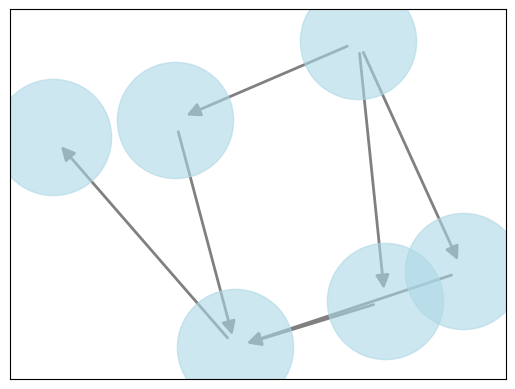

In [23]:
import matplotlib.pyplot as plt

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=7000, node_color='lightblue', alpha=0.6)

# Edges
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray', width=2)

# Node labels
node_labels = {node[0]: node[2]['name'] for node in data['nodes']}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)

# Edge labels
edge_labels = {(edge[0], edge[2]): edge[1] for edge in data['edges']}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title('Graph Visualization')
plt.axis('off')  # Turn off the axis
plt.show()  # Display the graph

In [21]:
data['nodes']

[['Oles Buzina', 'Person', {'source': 'social media', 'type': 'Person'}],
 ['Vladimir Zhirinovsky',
  'Person',
  {'source': 'social media', 'type': 'Person'}],
 ['Vladimir Solovyov', 'Person', {'source': 'social media', 'type': 'Person'}],
 ['Duel', 'Event', {'source': 'social media', 'type': 'Event'}],
 ['socio-political topics',
  'Topic',
  {'source': 'social media', 'type': 'Topic'}]]